## Fetal Immune - Myeloid / Lymphoid subset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import numpy as np 
import pandas as pd
import scanpy as sc
from datetime import datetime
import matplotlib.pyplot as plt

### Load data

In [3]:
adata = sc.read_h5ad("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210118.MYELOID_LYMPHOID.batchCorrected.h5ad")

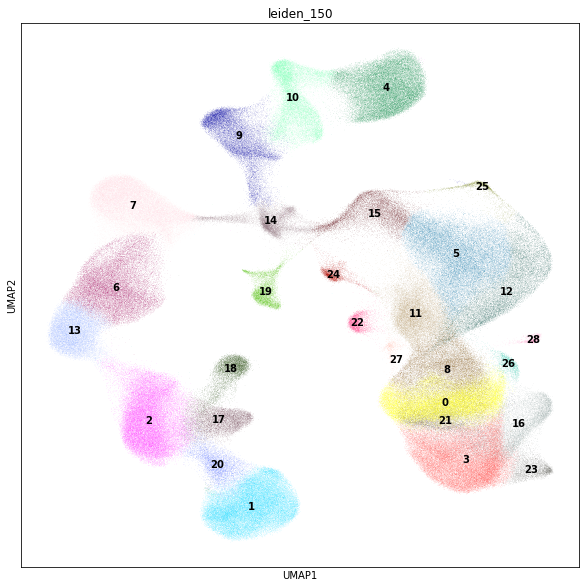

In [4]:
plt.rcParams["figure.figsize"] = [10,10]
sc.pl.umap(adata, color=["leiden_150"], legend_loc="on data")

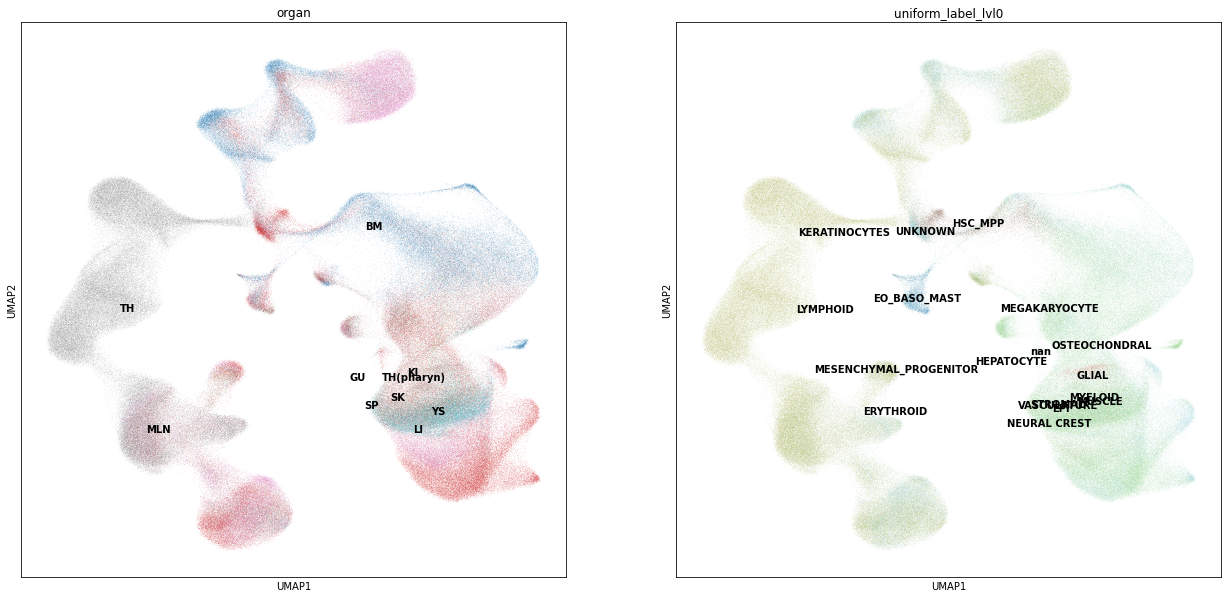

In [5]:
sc.pl.umap(adata, color=["organ", 'uniform_label_lvl0'], legend_loc="on data")

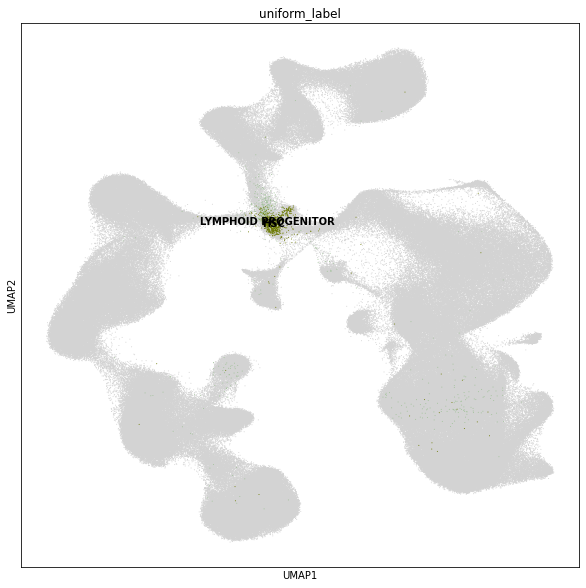

In [9]:
sc.pl.umap(adata, color=['uniform_label'], legend_loc="on data", 
               groups=["LYMPHOID PROGENITOR", "HSC"], size=4)

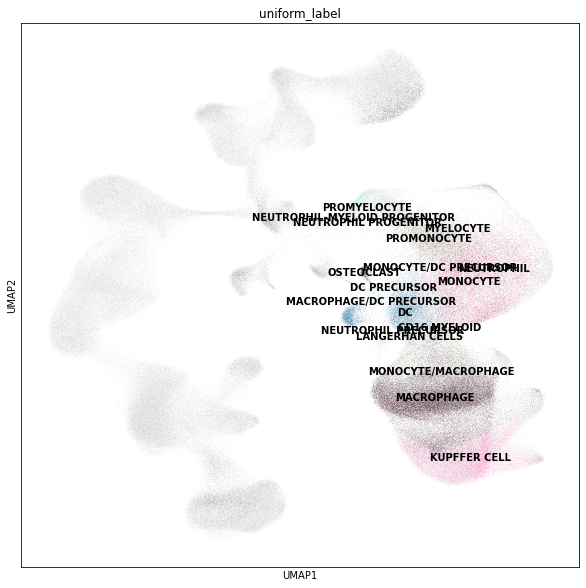

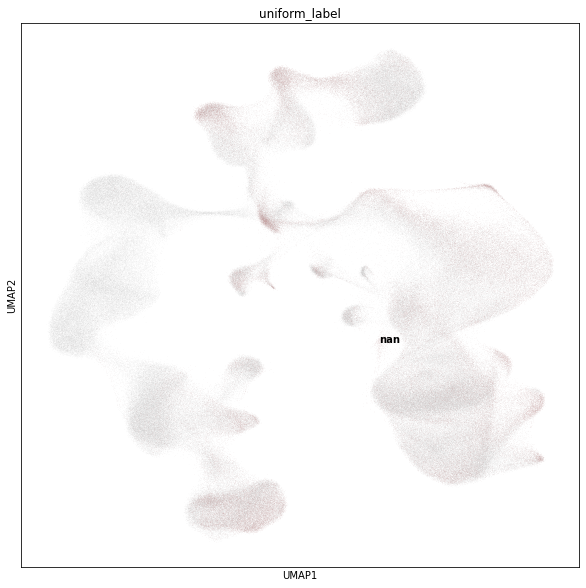

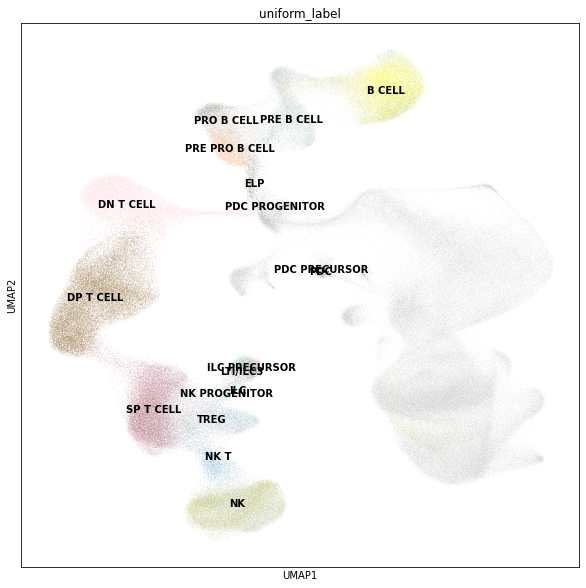

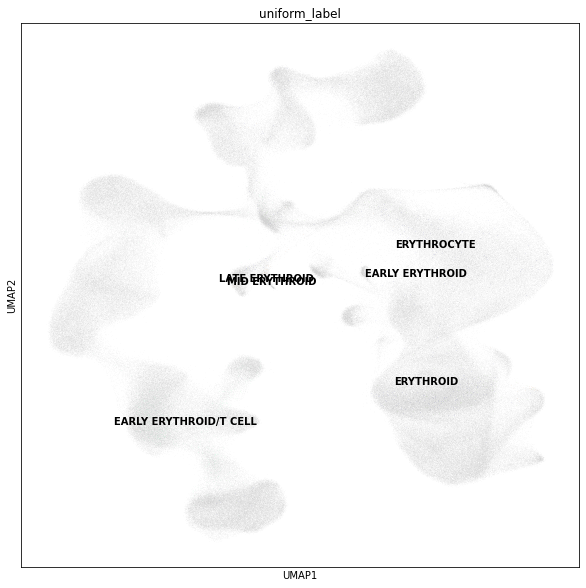

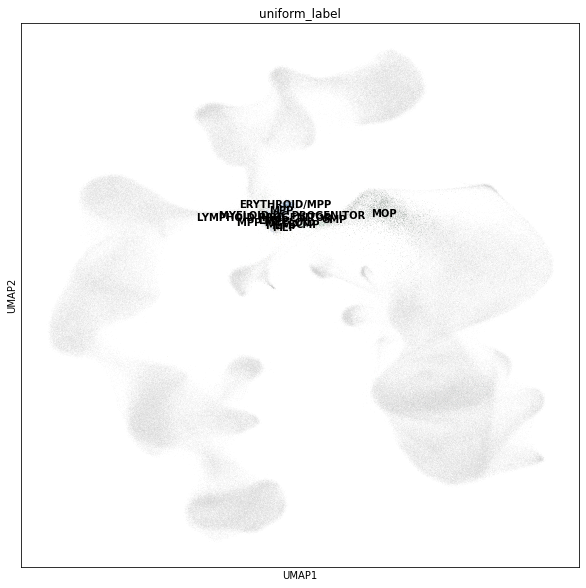

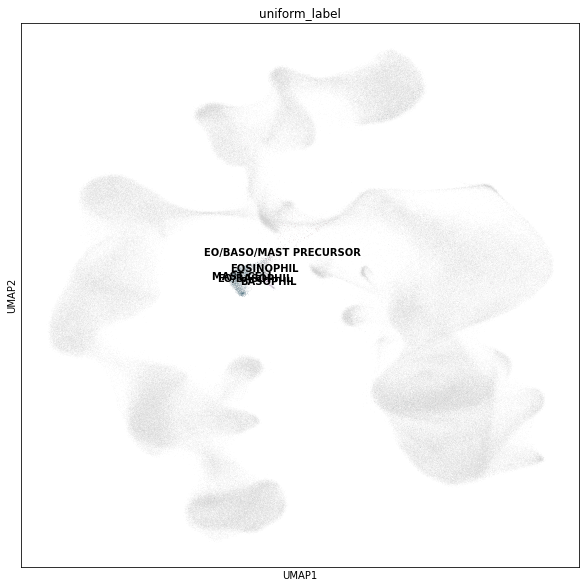

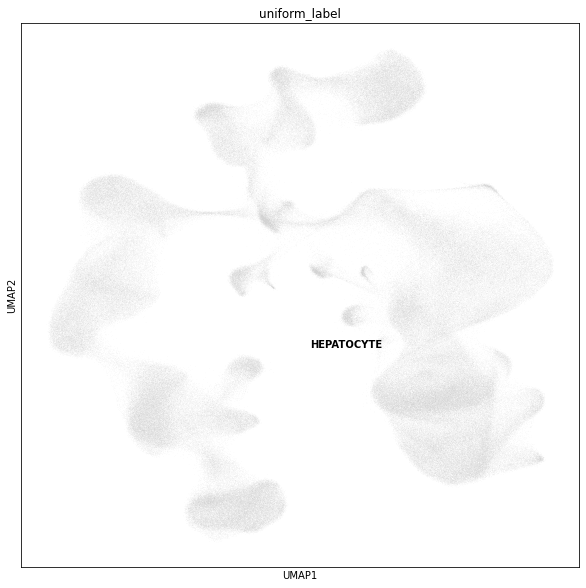

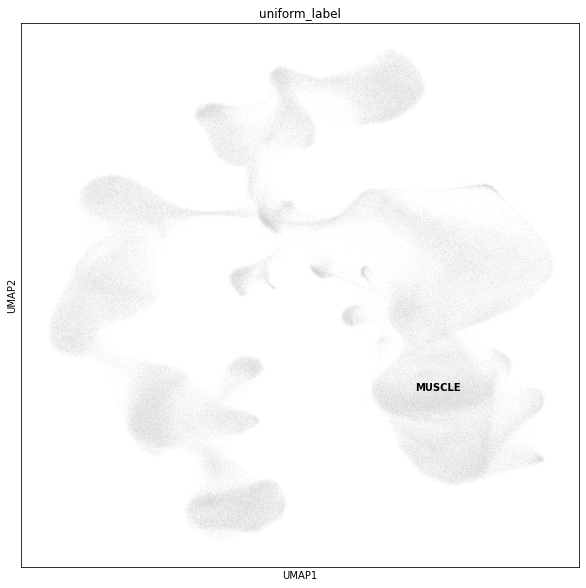

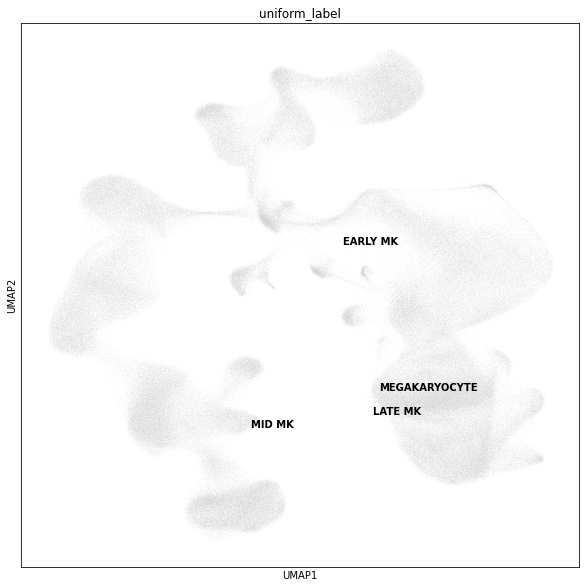

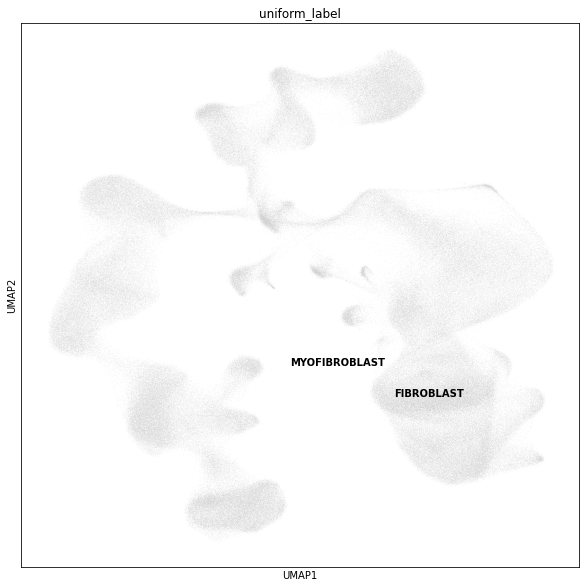

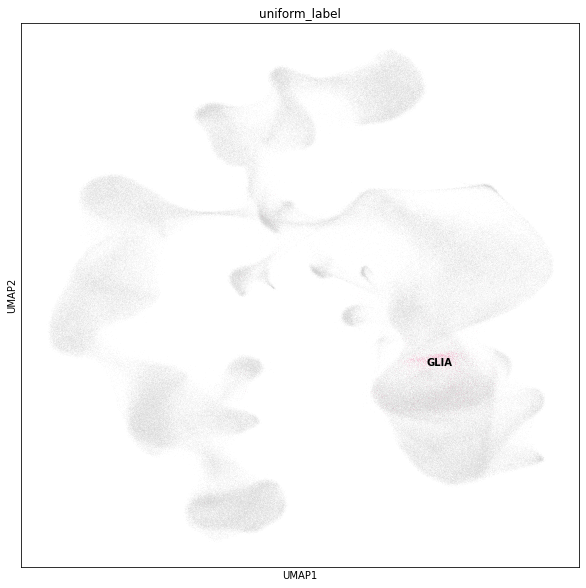

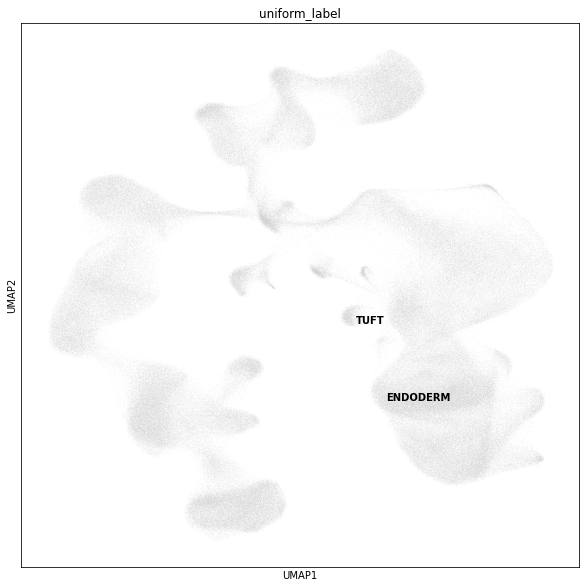

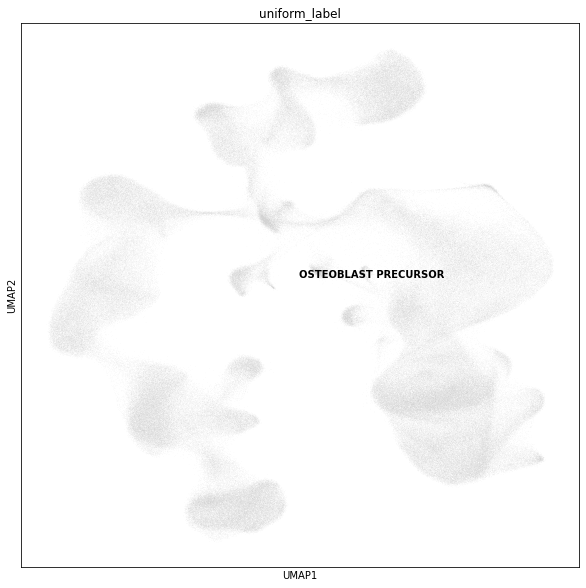

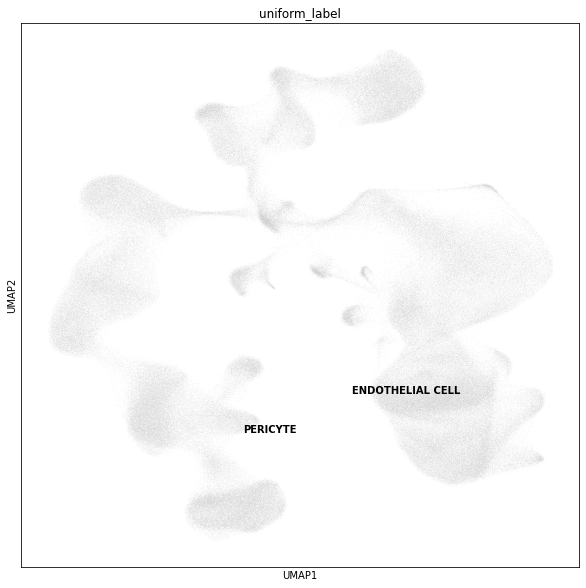

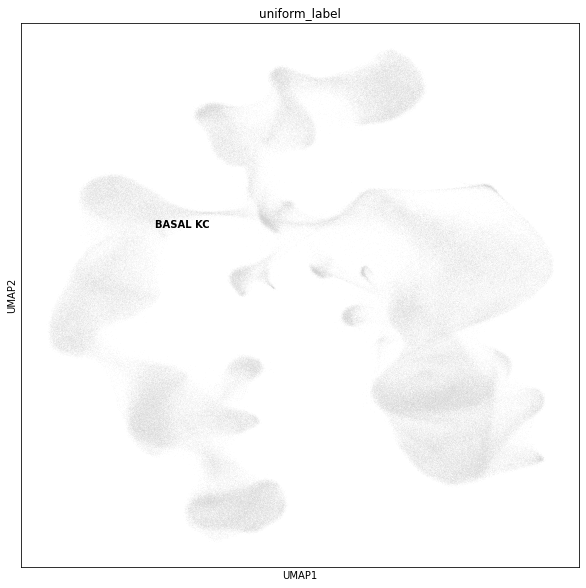

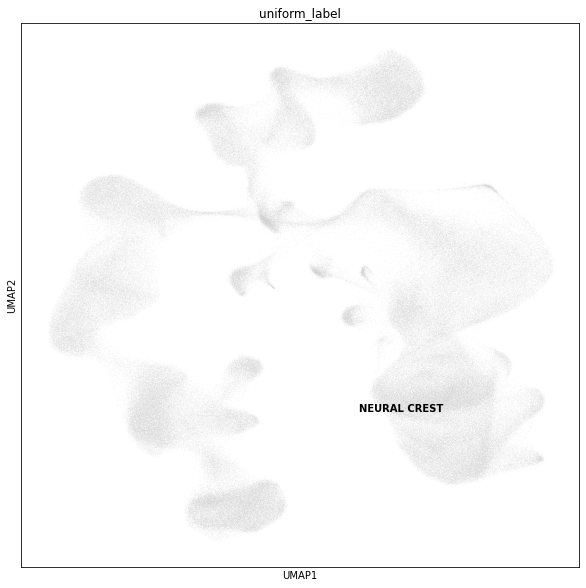

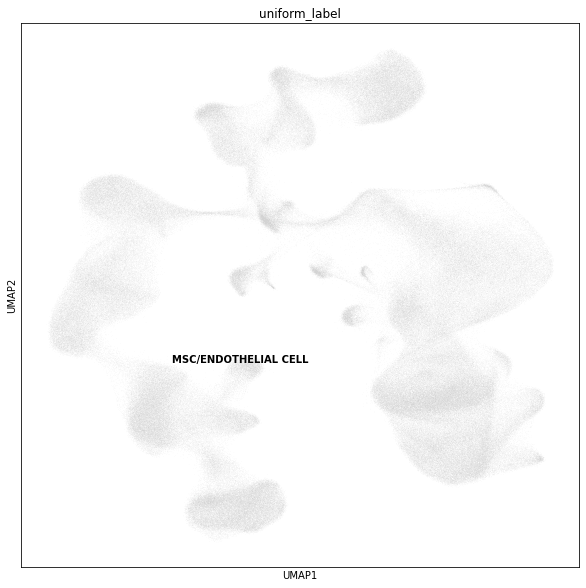

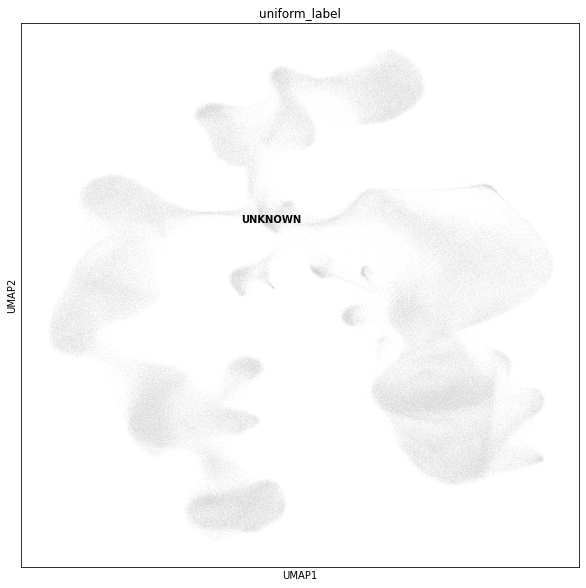

In [7]:
for o in adata.obs['uniform_label_lvl0'].unique():
    sc.pl.umap(adata, color=['uniform_label'], legend_loc="on data", 
               groups=adata.obs['uniform_label'][adata.obs['uniform_label_lvl0'] == o].unique())

### Annotate clusters using most frequent label 

In [8]:
## Add predicted lvl0 label based on most frequent cell type
cl_counts = adata.obs.reset_index()[['uniform_label_expanded_merged', 'leiden_150','index']] \
    .dropna() \
    .groupby(['leiden_150', 'uniform_label_expanded_merged']) \
    .count().fillna(0).reset_index() \
    .pivot(columns=['leiden_150'], index=['uniform_label_expanded_merged'])

cl_frac = (cl_counts/cl_counts.sum(0))
cl_frac.columns = ['index_' + str(x[1]) for x in cl_frac.columns]
max_cl = cl_frac.max()
top_3_ls = []
for cl in cl_frac.columns:
    top_3 = cl_frac[cl_frac.index!="nan"].nlargest(1, cl)[cl].index[0]
    top_3_ls.append(top_3)

pred_labels_df = pd.DataFrame(top_3_ls, columns=['leiden_150_pred_label'], index=[int(x.split("index_")[1]) for x in cl_frac.columns])

pred_labels_df.index = pred_labels_df.index.astype('str')
# pred_labels_df.loc[adata.obs['leiden_100']]['leiden_100_pred_label']

adata.obs['leiden_150_pred_label'] = pred_labels_df.loc[adata.obs['leiden_150']]['leiden_150_pred_label'].values

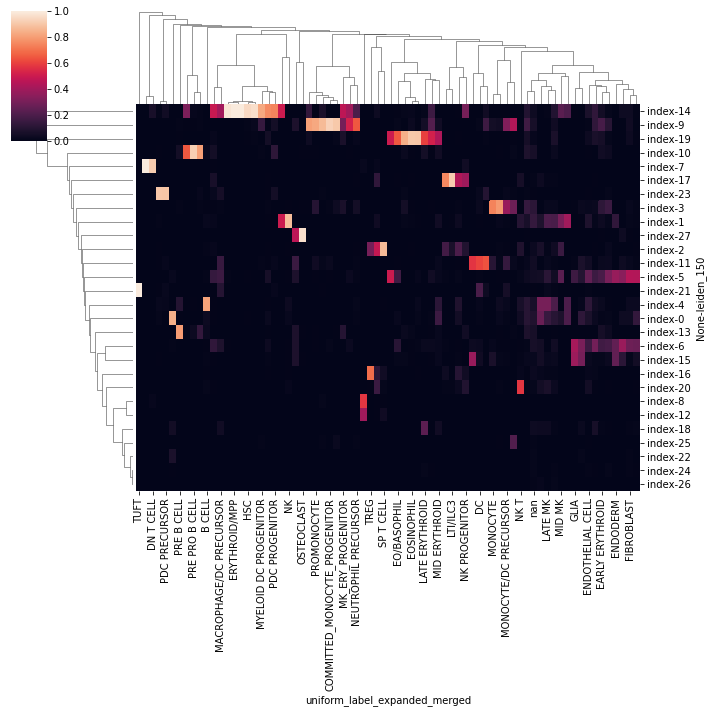

In [9]:
import seaborn as sns
sns.clustermap(cl_counts.T/cl_counts.sum(1))

... storing 'leiden_150_pred_label' as categorical


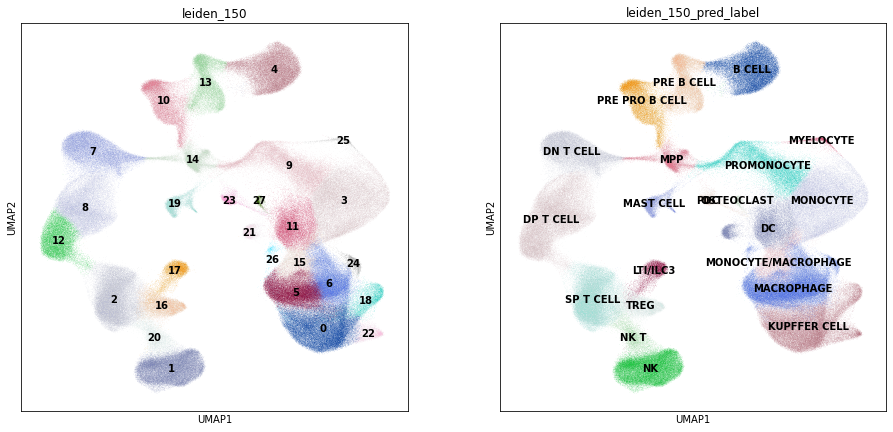

In [10]:
plt.rcParams["figure.figsize"] = [7,7]
sc.pl.umap(adata, color=["leiden_150", "leiden_150_pred_label"], legend_loc="on data")

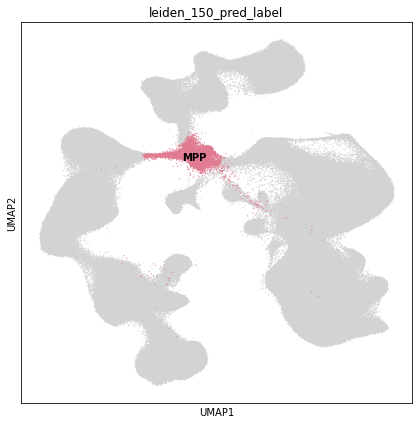

In [11]:
sc.pl.umap(adata, color=["leiden_150_pred_label"], legend_loc="on data", size=5, groups="MPP")

## Split in Myeloid/lymphoid

2 splits excluding pDCs and including MPPs

In [12]:
## Define hierarchy for making data subsets
pfi_splitting_df = adata.obs[['leiden_150_pred_label']].drop_duplicates()

pfi_splitting_df["split_LYMPHOID"] = [
    "LYMPHOID" if pfi_splitting_df['leiden_150_pred_label'].loc[i] in ["DN T CELL", "SP T CELL", "DP T CELL", "NK", "NK T", "MPP", "TREG", "LTI/ILC3"]
    else "LYMPHOID" if "B CELL" in pfi_splitting_df['leiden_150_pred_label'].loc[i]
#     else 'PDC' if "PDC" in pfi_splitting_df['leiden_150_pred_label'].loc[i]
    else np.nan
    for i in pfi_splitting_df.index
]

pfi_splitting_df["split_MYELOID"] = [
    "LYMPHOID" if pfi_splitting_df['leiden_150_pred_label'].loc[i] in ["DN T CELL", "SP T CELL", "DP T CELL", "NK", "NK T", "TREG", "LTI/ILC3"]
    else "LYMPHOID" if "B CELL" in pfi_splitting_df['leiden_150_pred_label'].loc[i]
    else 'PDC' if "PDC" in pfi_splitting_df['leiden_150_pred_label'].loc[i]
    else "MYELOID"
    for i in pfi_splitting_df.index
]

# pfi_splitting_df["split_3"] = ["MYELOID" if pfi_splitting_df["split_3"].loc[i] == "MYELOID/LYMPHOID" 
#                                else pfi_splitting_df["split_3"].loc[i] 
#                                for i in pfi_splitting_df.index
#                               ]
pfi_splitting_df["split_MYELOID"] = ['MYELOID' if pfi_splitting_df["split_MYELOID"].loc[i]=="MYELOID" else np.nan for i in pfi_splitting_df.index]
pfi_splitting_df

leiden_150_pred_label split_LYMPHOID  \
index                                                                  
FCAImmP7179363-AAACCTGAGCAGATCG          KUPFFER CELL            NaN   
FCAImmP7179363-AAACCTGAGCTGATAA            MACROPHAGE            NaN   
FCAImmP7179363-AAACCTGGTGAGTGAC        PRE PRO B CELL       LYMPHOID   
FCAImmP7179363-AAACGGGAGTTAGCGG                    NK       LYMPHOID   
FCAImmP7179363-AAACGGGCAATAACGA                B CELL       LYMPHOID   
FCAImmP7179363-AAACGGGCAGCCTGTG            PRE B CELL       LYMPHOID   
FCAImmP7179363-AAATGCCAGTGAATTG                    DC            NaN   
FCAImmP7179363-AACACGTGTTATGCGT   MONOCYTE/MACROPHAGE            NaN   
FCAImmP7179363-AACACGTTCGATAGAA             SP T CELL       LYMPHOID   
FCAImmP7179363-AACACGTTCGCAAGCC                   MPP       LYMPHOID   
FCAImmP7179363-AACCATGTCTAACTGG              MONOCYTE            NaN   
FCAImmP7179363-AACTCTTGTCTCTCGT           PROMONOCYTE            NaN   
FCAImmP7179363-AACTCTTTCGGAATCT                  NK T       LYMPHOID   
FCAImmP7179363-AACTTTCTCTCTAAGG                  TREG       LYMPHOID   
FCAImmP7179363-AAGCCGCCAATTGCTG                   PDC            NaN   
FCAImmP7179363-AAGGCAGGTCCGAGTC             MAST CELL            NaN   
FCAImmP7179363-CCTTACGCATCACAAC              LTI/ILC3       LYMPHOID   
FCAImmP7179366-CATCAGAGTGCAGGTA             DN T CELL       LYMPHOID   
FCAImmP7179367-AAACCTGGTCGTTGTA            OSTEOCLAST            NaN   
FCAImmP7179367-CGACTTCGTAGCCTAT             DP T CELL       LYMPHOID   
FCAImmP7179370-CGTGTCTTCTCATTCA             MYELOCYTE            NaN   

                                split_MYELOID  
index                                          
FCAImmP7179363-AAACCTGAGCAGATCG       MYELOID  
FCAImmP7179363-AAACCTGAGCTGATAA       MYELOID  
FCAImmP7179363-AAACCTGGTGAGTGAC           NaN  
FCAImmP7179363-AAACGGGAGTTAGCGG           NaN  
FCAImmP7179363-AAACGGGCAATAACGA           NaN  
FCAImmP7179363-AAACGGGCAGCCTGTG           NaN  
FCAImmP7179363-AAATGCCAGTGAATTG       MYELOID  
FCAImmP7179363-AACACGTGTTATGCGT       MYELOID  
FCAImmP7179363-AACACGTTCGATAGAA           NaN  
FCAImmP7179363-AACACGTTCGCAAGCC       MYELOID  
FCAImmP7179363-AACCATGTCTAACTGG       MYELOID  
FCAImmP7179363-AACTCTTGTCTCTCGT       MYELOID  
FCAImmP7179363-AACTCTTTCGGAATCT           NaN  
FCAImmP7179363-AACTTTCTCTCTAAGG           NaN  
FCAImmP7179363-AAGCCGCCAATTGCTG           NaN  
FCAImmP7179363-AAGGCAGGTCCGAGTC       MYELOID  
FCAImmP7179363-CCTTACGCATCACAAC           NaN  
FCAImmP7179366-CATCAGAGTGCAGGTA           NaN  
FCAImmP7179367-AAACCTGGTCGTTGTA       MYELOID  
FCAImmP7179367-CGACTTCGTAGCCTAT           NaN  
FCAImmP7179370-CGTGTCTTCTCATTCA       MYELOID

In [13]:
adata.obs = adata.obs[[x for x in adata.obs.columns if "split" not in x]]
adata.obs = adata.obs.merge(pfi_splitting_df, on=['leiden_150_pred_label'], how='left', indicator=False)

AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …


... storing 'split_LYMPHOID' as categorical
... storing 'split_MYELOID' as categorical


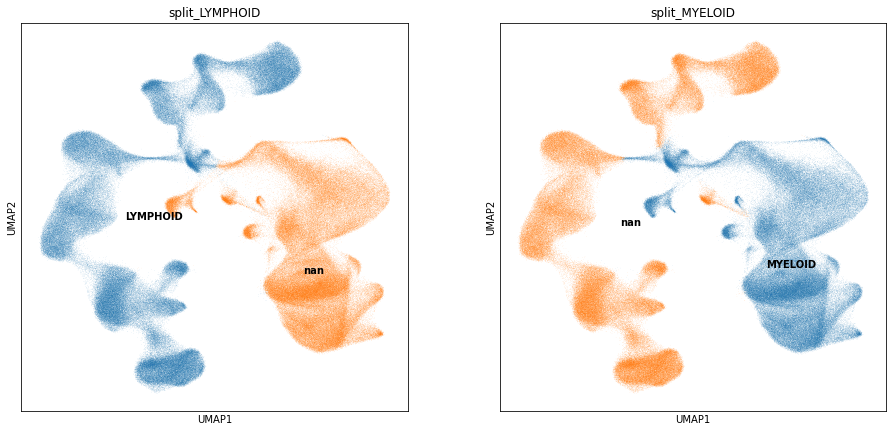

In [14]:
sc.pl.umap(adata, color=["split_LYMPHOID", "split_MYELOID"], legend_loc="on data")

In [15]:
adata_raw = sc.read_h5ad('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210118.MYELOID_LYMPHOID.h5ad')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [16]:
adata_raw = adata_raw[adata.obs_names]

In [17]:
save_path = '/nfs/team205/ed6/data/Fetal_immune/'
suffix = 'PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210118'

In [18]:
for s in ['MYELOID', 'LYMPHOID']:
    split_col = 'split_' + s
    adata_name = save_path + "{}.{}.h5ad".format(suffix, s)
    sdata = adata_raw[adata.obs[split_col]==s]
    print("Saving {} anndata ({} cells, {} organs)".format(s, sdata.obs_names.shape[0], sdata.obs["organ"].unique().shape[0]))
    sdata.write_h5ad(adata_name)

Saving MYELOID anndata (219974 cells, 10 organs)
Saving LYMPHOID anndata (244452 cells, 10 organs)
